**Tratamiento de Bases y analisis exploratorio inicial, Analisis de Seguros**

Angela Chamorro

Vladimir Martin

Analitica 3

UdeA 2023-2

#Preliminares

Antes de ejecutar, subir al entorno las 7 bases de datos suministradas

##Paquetes y funciones

###Paquetes pre-procesamiento

In [17]:
!pip install ydata_profiling

In [18]:
!pip install typing_extensions==4.7.1 --upgrade

In [19]:
from ydata_profiling  import ProfileReport

In [20]:
#IMPORTAR PAQUETES
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [21]:
#funcion para convertir fecha excel a date_time
#to_datetime tiene una base en 01-01-1970(que equivale a 25569), entonces al restar, sacamos los dias desde 1970 a la fecha respectiva
#despues lo multiplicamos por el numero de segundos por dia (86400) y esto se lo damos a to_datetime especificando que esta en segundos

def exceldate(n):
    seconds = (n - 25569) * 86400.0
    return pd.to_datetime(seconds,unit="s")


In [22]:
def reemplazar_numerico(valor):
    return 'Si' if pd.notna(valor) and isinstance(valor, (int, float)) else "No"

##Cargar las Bases de Datos

In [23]:
#base de datos de Utilizaciones medicas
df_utl = pd.read_csv("BD_UtilizacionesMedicas.csv", sep=";")
#base de datos de datos Socio Demograficas
df_scd = pd.read_csv("BD_SocioDemograficas.csv", sep=";")
#base de datos asegurados expuestos
df_aseg = pd.read_csv("BD_Asegurados_Expuestos.csv", sep=";")
#base de datos diccionario Diagnostico
df_diag = pd.read_csv("/content/BD_Diagnostico.csv", sep=";")
#base de datos diccionario genero
df_gen = pd.read_csv("/content/BD_Genero.csv", sep=";")
#base de datos diccionario regional
df_reg = pd.read_csv("/content/BD_Regional.csv", sep=";")
#base de datos diccionario reclamaciones
df_recl = pd.read_csv("/content/BD_Reclamaciones.csv", sep=";")


<ipython-input-23-aa08c0254274>:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_scd = pd.read_csv("BD_SocioDemograficas.csv", sep=";")


#Tratamiento y Analisis

##Base Socio Demograficas

In [24]:
#visualizamos la bd Socio Demograficas
df_scd.head(3)

Afiliado_Id  Sexo_Cd  FechaNacimiento Regional  CANCER  EPOC  DIABETES  \
0       738288        2            28072       40       0     0         0   
1       738294        2            23392       50       0     0         0   
2       738303        1            27177       10       0     0         0   

   HIPERTENSION  ENF_CARDIOVASCULAR  
0             0                   0  
1             0                   0  
2             0                   0

In [25]:
print("Esta base tiene",df_scd.shape[0],"Registros", "que corresponden a",df_scd['Afiliado_Id'].nunique(), "afiliados. ")
#la base deberia tener todos los valores unicos,pero existen 13 registros repetidos de afiliados.

Esta base tiene 225776 Registros que corresponden a 225763 afiliados. 


In [26]:
#ver registros repetidos
df_scd[df_scd.duplicated(subset="Afiliado_Id",keep=False)].head(4)


Afiliado_Id  Sexo_Cd  FechaNacimiento Regional  CANCER  EPOC  \
142499     31730923        1            41671       10       0     0   
142500     31730923        1            41671       40       0     0   
157276     36189021        2            41427       30       0     0   
157277     36189021        2            41427       40       0     0   

        DIABETES  HIPERTENSION  ENF_CARDIOVASCULAR  
142499         0             0                   0  
142500         0             0                   0  
157276         0             0                   0  
157277         0             0                   0

-Nos damos cuenta que se repite el registro por cliente porque se hace el ingreso de otra afiliacion en otra regional.

In [27]:
#se decide dejar para cada afiliado con registro duplicado, la ultima regional asignada segun el orden en la base de datos.
elim=df_scd[df_scd.duplicated(subset="Afiliado_Id",keep="first")]
df_scd=df_scd.drop(elim.index.tolist())
print("Se deja unicamente el ultimo registro por afiliado, se obtiene entonces que: ")
print("Esta base tiene",df_scd.shape[0],"Registros", "que corresponden a",df_scd['Afiliado_Id'].nunique(), "afiliados")

Se deja unicamente el ultimo registro por afiliado, se obtiene entonces que: 
Esta base tiene 225763 Registros que corresponden a 225763 afiliados


##Base Utilizaciones Medicas

In [28]:
#visualizamo la bd de  Utilizaciones medicas
df_utl.head(3)

Fecha_Reclamacion  Afiliado_Id Reclamacion_Cd Diagnostico_Codigo  \
0              43766      2668445            R10                  9   
1              43738      4370072            R15                  9   
2              43766      7567894            R14               N649   

   Numero_Utilizaciones  Valor_Utilizaciones  
0                     1                46500  
1                     2                42408  
2                     1               139376

In [29]:
print("Esta base tiene",df_utl.shape[0],"Registros", "que corresponden a",df_utl['Afiliado_Id'].nunique(), "afiliados")

Esta base tiene 800232 Registros que corresponden a 161748 afiliados


##Base Asegurados Expuestos

In [30]:
#visualizamos la bd asegurados expuestos
df_aseg

Asegurado_Id  Poliza_Id  FECHA_INICIO  FECHA_CANCELACION  FECHA_FIN
0            1213170  113307876         43709                NaN      43814
1           22248110  195410143         43709            43830.0      43830
2            7212095  192799506         43709            43830.0      43830
3           23743715  145500123         43709            43830.0      43830
4           57822199  175415440         43709            43830.0      43830
...              ...        ...           ...                ...        ...
231515       1475469  129009780         43709                NaN      43830
231516       5867040  122473992         43709                NaN      43830
231517      17992105  160393703         43709                NaN      43830
231518      48708455  156289019         43709                NaN      43830
231519      30913881  201345473         43709            43830.0      43830

[231520 rows x 5 columns]

In [31]:
#vemos que algunos usuarios cancelan la poliza despues del fin de la misma.
pp=df_aseg[df_aseg["FECHA_CANCELACION"].notna()]
pp[pp["FECHA_CANCELACION"]!=pp["FECHA_FIN"]].head(3)

Asegurado_Id  Poliza_Id  FECHA_INICIO  FECHA_CANCELACION  FECHA_FIN
9234        2461341  123364068         43709            43825.0      43770
10394      45012207  197936354         43709            43784.0      43768
18248      30662011  201582576         43747            43790.0      43777

vemos que algunos usuarios cancelan la poliza despues del fin de la misma.

In [32]:
#vemos que de ella podemos extraer dos variables utiles para el modelo, el tiempo de duracion de la poliza y si la poliza fue cancelada o no.
#convertimos columnas a formato fecha
df_aseg["FECHA_INICIO"]=exceldate(df_aseg["FECHA_INICIO"])
df_aseg["FECHA_FIN"]=exceldate(df_aseg["FECHA_FIN"])
#creamos la columna duracion poliza
df_aseg["DUR_POL"]=(df_aseg['FECHA_FIN']-df_aseg["FECHA_INICIO"]).astype("<m8[D]")+1 #se le suma 1 ya que se cuenta el dia de inicio desde las 00:00 entonces se se acaba la poliza el mismo dia, la duracion seria 1 dia, no 0.
#Creamos la columna cancelacion
df_aseg["CANCEL"]=df_aseg["FECHA_CANCELACION"].apply(reemplazar_numerico)
#Eliminamos la columna FECHA_CANCELACION
df_aseg=df_aseg.drop("FECHA_CANCELACION",axis=1)
#Renombramos la columna asegurado_id
df_aseg.rename(columns={"Asegurado_Id":"Afiliado_Id"},inplace=True)


In [33]:
print("base de datos con el tiempo de duracion de la poliza y si la poliza fue cancelada o no")
df_aseg.head(3)

base de datos con el tiempo de duracion de la poliza y si la poliza fue cancelada o no


Afiliado_Id  Poliza_Id FECHA_INICIO  FECHA_FIN  DUR_POL CANCEL
0      1213170  113307876   2019-09-01 2019-12-15    106.0     No
1     22248110  195410143   2019-09-01 2019-12-31    122.0     Si
2      7212095  192799506   2019-09-01 2019-12-31    122.0     Si

In [34]:
#se analiza si hay mas de 1 poliza por asegurado
print("Esta base tiene",df_aseg.shape[0],"polizas", "que corresponden a",df_aseg['Afiliado_Id'].nunique(), "afiliados")

Esta base tiene 231520 polizas que corresponden a 225763 afiliados


existen afiliados con mas de 1 poliza

In [35]:
#existen clientes con polizas seguidas, otros con polizas sepradas, y otros con varias polizas al tiempo.
df_aseg[df_aseg.duplicated(subset="Afiliado_Id",keep=False)].sort_values(by='Afiliado_Id', ascending=False)

Afiliado_Id  Poliza_Id FECHA_INICIO  FECHA_FIN  DUR_POL CANCEL
221985     60975491  191752551   2019-09-01 2019-11-28     89.0     Si
76640      60975491  203954951   2019-11-30 2019-12-31     32.0     No
4999       60750733  126260749   2019-09-01 2019-12-31    122.0     No
212584     60750733  126266526   2019-09-01 2019-12-31    122.0     No
38440      60645652  203353878   2019-12-01 2019-12-31     31.0     No
...             ...        ...          ...        ...      ...    ...
92053        738886   91476427   2019-09-01 2019-10-30     60.0     Si
14897        738886  201222934   2019-10-30 2019-10-31      2.0     Si
22270        738886  202863837   2019-10-31 2019-12-31     62.0     Si
114247       738443  203732930   2019-11-12 2019-12-31     50.0     No
127234       738443  119397955   2019-09-01 2019-11-12     73.0     Si

[11166 rows x 6 columns]

from matplotlib import pyplot as plt
_df_0['Afiliado_Id'].plot(kind='hist', bins=20, title='Afiliado_Id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Poliza_Id'].plot(kind='hist', bins=20, title='Poliza_Id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['DUR_POL'].plot(kind='hist', bins=20, title='DUR_POL')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('CANCEL').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Afiliado_Id', y='Poliza_Id', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Poliza_Id', y='DUR_POL', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['FECHA_INICIO']
  ys = series['Afiliado_Id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('FECHA_INICIO', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('CANCEL')):
  _plot_series(series, series_name, i)
  fig.legend(title='CANCEL', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('FECHA_INICIO')
_ = plt.ylabel('Afiliado_Id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['FECHA_INICIO']
  ys = series['Poliza_Id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('FECHA_INICIO', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('CANCEL')):
  _plot_series(series, series_name, i)
  fig.legend(title='CANCEL', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('FECHA_INICIO')
_ = plt.ylabel('Poliza_Id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['FECHA_INICIO']
  ys = series['DUR_POL']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('FECHA_INICIO', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('CANCEL')):
  _plot_series(series, series_name, i)
  fig.legend(title='CANCEL', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('FECHA_INICIO')
_ = plt.ylabel('DUR_POL')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['FECHA_INICIO']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'FECHA_INICIO'}, axis=1)
              .sort_values('FECHA_INICIO', ascending=True))
  xs = counted['FECHA_INICIO']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('FECHA_INICIO', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('CANCEL')):
  _plot_series(series, series_name, i)
  fig.legend(title='CANCEL', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('FECHA_INICIO')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_10['Afiliado_Id'].plot(kind='line', figsize=(8, 4), title='Afiliado_Id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Poliza_Id'].plot(kind='line', figsize=(8, 4), title='Poliza_Id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['DUR_POL'].plot(kind='line', figsize=(8, 4), title='DUR_POL')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['CANCEL'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='Afiliado_Id', y='CANCEL', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['CANCEL'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='Poliza_Id', y='CANCEL', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['CANCEL'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='DUR_POL', y='CANCEL', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

De los clientes con varias polizas, se pueden ver que unos las renuevan se forma inmediata, otros con un tiempo de separacion y otros tienen varias polizas al tiempo, esto ultimo debido posiblemente a que estan a nombre de un solo titular, pero los beneficiarios pueden ser diferentes

**Analisis de cancelaciones**

****Si genera error, dar click en la generacion de graficos de la tabla anterior, despues si ejecutar las lineas de codigo siguientes****

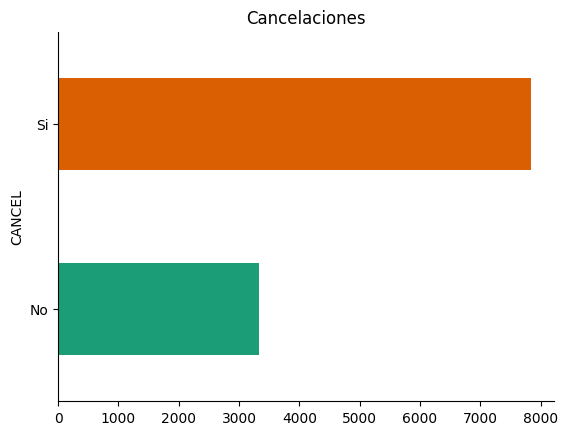

In [37]:
import seaborn as sns
_df_3.groupby('CANCEL').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'),title='Cancelaciones')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [38]:
print("Porcentajes de cancelaciones")
((df_aseg['CANCEL'].value_counts()/len(df_aseg))*100).round(2)


Porcentajes de cancelaciones


No    54.73
Si    45.27
Name: CANCEL, dtype: float64

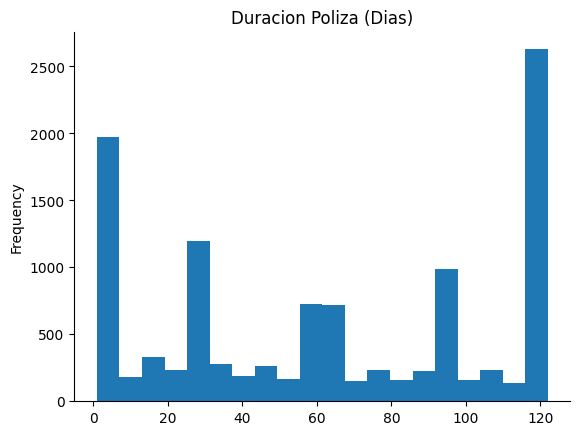

In [39]:
from matplotlib import pyplot as plt
_df_2['DUR_POL'].plot(kind='hist', bins=20, title='Duracion Poliza (Dias)')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [40]:
#se decide promediar los dias de duracion de las polizas para tener un promedio de dias asegurado por cliente.
df_aseg_prom=df_aseg.groupby("Afiliado_Id")["DUR_POL"].mean().reset_index()
#se cuenta despues, para cada duracion, el numero de usuarios con esta duracion
pd.DataFrame(df_aseg_prom['DUR_POL'].value_counts().reset_index()).head(5).rename(columns={'index': 'Dias_Promedio',"DUR_POL":"Usuarios"}).sort_values(by='Dias_Promedio', ascending=False)

Dias_Promedio  Usuarios
0          122.0    199890
4           92.0      1303
1           61.5      3130
3           31.0      1407
2            1.0      1884

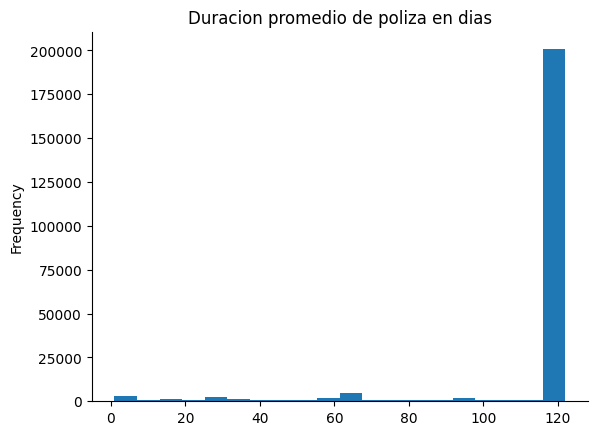

In [41]:
df_aseg_prom['DUR_POL'].plot(kind='hist', bins=20, title='Duracion promedio de poliza en dias')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [42]:
print("Un ",round((199890/len(df_aseg_prom))*100,2),"% de los usuarios, tienen polizas con una duracion de 122 dias, o 4 meses aprox")

Un  88.54 % de los usuarios, tienen polizas con una duracion de 122 dias, o 4 meses aprox


##Union de las Bases

In [43]:
#Unimos las bd de utilizaciones Medicas y socio demograficos desde el Afiliado_Id.
df_completa = pd.merge(df_utl, df_scd, on='Afiliado_Id', how='left')
df_completa.head(3)

Fecha_Reclamacion  Afiliado_Id Reclamacion_Cd Diagnostico_Codigo  \
0              43766      2668445            R10                  9   
1              43738      4370072            R15                  9   
2              43766      7567894            R14               N649   

   Numero_Utilizaciones  Valor_Utilizaciones  Sexo_Cd  FechaNacimiento  \
0                     1                46500      1.0          22999.0   
1                     2                42408      1.0          24071.0   
2                     1               139376      1.0          28985.0   

  Regional  CANCER  EPOC  DIABETES  HIPERTENSION  ENF_CARDIOVASCULAR  
0       50     0.0   0.0       0.0           1.0                 0.0  
1       10     0.0   0.0       0.0           0.0                 0.0  
2       40     0.0   0.0       0.0           0.0                 0.0

In [44]:
 #puede haber varios registros por afiliado, es decir, afiliados con varias reclamaciones.
 print("Estas son las reclamaciones para el afiliado ID=2668445\n")
 df_completa.loc[df_completa['Afiliado_Id'] == 2668445]

Estas son las reclamaciones para el afiliado ID=2668445



Fecha_Reclamacion  Afiliado_Id Reclamacion_Cd Diagnostico_Codigo  \
0                   43766      2668445            R10                  9   
428138              43739      2668445            R10                  9   
479193              43719      2668445            R10                  9   
625599              43728      2668445            R18                  9   

        Numero_Utilizaciones  Valor_Utilizaciones  Sexo_Cd  FechaNacimiento  \
0                          1                46500      1.0          22999.0   
428138                     1                55676      1.0          22999.0   
479193                     2               157852      1.0          22999.0   
625599                     6                76455      1.0          22999.0   

       Regional  CANCER  EPOC  DIABETES  HIPERTENSION  ENF_CARDIOVASCULAR  
0            50     0.0   0.0       0.0           1.0                 0.0  
428138       50     0.0   0.0       0.0           1.0                 0.0  
479193       50     0.0   0.0       0.0           1.0                 0.0  
625599       50     0.0   0.0       0.0           1.0                 0.0

In [45]:
#Dimension de la base
print('La dimensión de los datos es:', df_completa.shape, 'con', df_completa.shape[0], 'registros y ', df_completa.shape[1], 'columnas')
#valores nulos
print("\n       ###valores nulos###\n")
df_completa.isnull().sum()

La dimensión de los datos es: (800232, 14) con 800232 registros y  14 columnas

       ###valores nulos###



Fecha_Reclamacion          0
Afiliado_Id                0
Reclamacion_Cd             0
Diagnostico_Codigo         0
Numero_Utilizaciones       0
Valor_Utilizaciones        0
Sexo_Cd                 3052
FechaNacimiento         3052
Regional                3052
CANCER                  3052
EPOC                    3052
DIABETES                3052
HIPERTENSION            3052
ENF_CARDIOVASCULAR      3052
dtype: int64

In [46]:
#buscamos los registros con valores nulos(los cuales corresponden a las variables de la base de datos de socio demograficas)
df_completa[df_completa['Sexo_Cd'].isnull()].head(3)

Fecha_Reclamacion  Afiliado_Id Reclamacion_Cd Diagnostico_Codigo  \
407              43337     40522640             R8                  9   
608              43697      9871226            R22               I500   
647              43699     48636409            R10                  9   

     Numero_Utilizaciones  Valor_Utilizaciones  Sexo_Cd  FechaNacimiento  \
407                     1                46664      NaN              NaN   
608                     1               322148      NaN              NaN   
647                     1                85312      NaN              NaN   

    Regional  CANCER  EPOC  DIABETES  HIPERTENSION  ENF_CARDIOVASCULAR  
407      NaN     NaN   NaN       NaN           NaN                 NaN  
608      NaN     NaN   NaN       NaN           NaN                 NaN  
647      NaN     NaN   NaN       NaN           NaN                 NaN

In [47]:
 #tomamos un valor de ejemplo, para buscarlo en la base de datos de sociodemograficas y descartar un error en el merge
 df_scd.loc[df_scd['Afiliado_Id'] == 40522640]
 #se puede ver que el origen de estos 3052 valores nulos es debido a que son clientes que utilizaron los servicios, pero no se encuentran en la base de datos demograficos.
print("De un total de ",df_completa.shape[0] ,"registros y ",df_completa['Afiliado_Id'].nunique(),"clientes, " ,df_completa["Sexo_Cd"].isnull().sum() ," registros no tienen datos demograficos. \nEsto corresponde a ", df_completa[df_completa['Sexo_Cd'].isnull()]["Afiliado_Id"].unique().shape[0],"clientes,un ",round((df_completa[df_completa['Sexo_Cd'].isnull()]["Afiliado_Id"].unique().shape[0])/(df_completa.shape[0])*100,2),"%,que al no tener datos completos, seran eliminados de la base de datos")

elim2=df_completa[df_completa["Sexo_Cd"].isnull()]
df_completa=df_completa.drop(elim2.index.tolist())


De un total de  800232 registros y  161748 clientes,  3052  registros no tienen datos demograficos. 
Esto corresponde a  1741 clientes,un  0.22 %,que al no tener datos completos, seran eliminados de la base de datos


In [48]:
#Debido a que nos interesa predecir las utilizaciones y los costos de estas teniendo en cuenta el tipo de diagnostico, eliminamos las filas con diagnostico pendiente o sin diagnostico
df_completa=df_completa[df_completa["Diagnostico_Codigo"]!= "9"].reset_index(drop=True) #Diagnositco pendiente
df_compleya=df_completa[df_completa["Diagnostico_Codigo"]!= "0"].reset_index(drop=True) #Diagnostico pendiente
df_completa=df_completa[df_completa["Diagnostico_Codigo"]!= "-1"].reset_index(drop=True) #sin diagnositco


In [49]:
#pasamos la columna de Fecha de Nacimiento a formato fecha
df_completa["FechaNacimiento"]=exceldate(df_completa["FechaNacimiento"])
#pasamos la columna de Fecha Reclamación a formato fecha
df_completa["Fecha_Reclamacion"]=exceldate(df_completa["Fecha_Reclamacion"])
#creamos columna edad
df_completa["Edad"]=(df_completa['Fecha_Reclamacion']-df_completa["FechaNacimiento"]).astype("<m8[Y]")
df_completa.head(5)

Fecha_Reclamacion  Afiliado_Id Reclamacion_Cd Diagnostico_Codigo  \
0        2019-10-28      7567894            R14               N649   
1        2019-12-23     12170310            R14               R529   
2        2019-12-09      4512914            R14               Z108   
3        2019-08-17      3212499            R14               R072   
4        2019-12-10      9055837            R25               S934   

   Numero_Utilizaciones  Valor_Utilizaciones  Sexo_Cd FechaNacimiento  \
0                     1               139376      1.0      1979-05-10   
1                     1               135179      1.0      1979-04-14   
2                     1                61854      1.0      1952-10-26   
3                     1               182900      2.0      1965-10-03   
4                     1               122053      1.0      1972-04-29   

  Regional  CANCER  EPOC  DIABETES  HIPERTENSION  ENF_CARDIOVASCULAR  Edad  
0       40     0.0   0.0       0.0           0.0                 0.0  40.0  
1       40     0.0   0.0       0.0           0.0                 0.0  40.0  
2       50     0.0   0.0       0.0           0.0                 0.0  67.0  
3       50     0.0   0.0       0.0           1.0                 0.0  53.0  
4       50     0.0   0.0       0.0           1.0                 0.0  47.0

In [50]:
#dimension de la base
print('La dimensión de los datos es:', df_completa.shape, 'con', df_completa.shape[0], 'registros y ', df_completa.shape[1], 'columnas')
#valores nulos
print("\n       ###valores nulos###\n")
df_completa.isnull().sum()

La dimensión de los datos es: (100678, 15) con 100678 registros y  15 columnas

       ###valores nulos###



Fecha_Reclamacion       0
Afiliado_Id             0
Reclamacion_Cd          0
Diagnostico_Codigo      0
Numero_Utilizaciones    0
Valor_Utilizaciones     0
Sexo_Cd                 0
FechaNacimiento         0
Regional                0
CANCER                  0
EPOC                    0
DIABETES                0
HIPERTENSION            0
ENF_CARDIOVASCULAR      0
Edad                    0
dtype: int64

In [51]:
#revisamos el tipo de datos que tenemos en cada variable
df_completa.dtypes

Fecha_Reclamacion       datetime64[ns]
Afiliado_Id                      int64
Reclamacion_Cd                  object
Diagnostico_Codigo              object
Numero_Utilizaciones             int64
Valor_Utilizaciones              int64
Sexo_Cd                        float64
FechaNacimiento         datetime64[ns]
Regional                        object
CANCER                         float64
EPOC                           float64
DIABETES                       float64
HIPERTENSION                   float64
ENF_CARDIOVASCULAR             float64
Edad                           float64
dtype: object

In [52]:
df_completa_1=df_completa.copy()

In [53]:
#ya que los modelos no son muy buenos interpretando valores de fecha, extraemos de las variables que puedan aportar al modelo
#podemos extraer el mes de la reclamacion, de nacimiento y el año de reclamacion, el año de nacimiento es equivalente a la edad.
df_completa_1["mes_rec"]=df_completa_1["Fecha_Reclamacion"].dt.month
df_completa_1["año_rec"]=df_completa_1["Fecha_Reclamacion"].dt.year
df_completa_1["mes_nac"]=df_completa_1["FechaNacimiento"].dt.month

In [54]:
df_completa_1.head(2)

Fecha_Reclamacion  Afiliado_Id Reclamacion_Cd Diagnostico_Codigo  \
0        2019-10-28      7567894            R14               N649   
1        2019-12-23     12170310            R14               R529   

   Numero_Utilizaciones  Valor_Utilizaciones  Sexo_Cd FechaNacimiento  \
0                     1               139376      1.0      1979-05-10   
1                     1               135179      1.0      1979-04-14   

  Regional  CANCER  EPOC  DIABETES  HIPERTENSION  ENF_CARDIOVASCULAR  Edad  \
0       40     0.0   0.0       0.0           0.0                 0.0  40.0   
1       40     0.0   0.0       0.0           0.0                 0.0  40.0   

   mes_rec  año_rec  mes_nac  
0       10     2019        5  
1       12     2019        4

In [55]:
#hacemos un analisis general
df_completa_1.describe()

Afiliado_Id  Numero_Utilizaciones  Valor_Utilizaciones        Sexo_Cd  \
count  1.006780e+05         100678.000000         1.006780e+05  100678.000000   
mean   1.750154e+07              1.024921         1.328091e+06       1.379894   
std    1.531496e+07              0.166663         5.745133e+06       0.485363   
min    7.383180e+05              1.000000         3.790000e+02       1.000000   
25%    4.734831e+06              1.000000         6.470200e+04       1.000000   
50%    1.205593e+07              1.000000         1.482540e+05       1.000000   
75%    2.768288e+07              1.000000         6.212400e+05       2.000000   
max    6.115209e+07              5.000000         5.410007e+08       2.000000   

              CANCER           EPOC       DIABETES   HIPERTENSION  \
count  100678.000000  100678.000000  100678.000000  100678.000000   
mean        0.075021       0.018852       0.084030       0.193319   
std         0.263427       0.136004       0.277435       0.394903   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

       ENF_CARDIOVASCULAR           Edad        mes_rec        año_rec  \
count       100678.000000  100678.000000  100678.000000  100678.000000   
mean             0.014879      42.547627       9.416764    2018.995133   
std              0.121070      20.169827       1.828264       0.078703   
min              0.000000      -2.000000       1.000000    2015.000000   
25%              0.000000      31.000000       9.000000    2019.000000   
50%              0.000000      42.000000      10.000000    2019.000000   
75%              0.000000      57.000000      11.000000    2019.000000   
max              1.000000     102.000000      12.000000    2019.000000   

             mes_nac  
count  100678.000000  
mean        6.579541  
std         3.471375  
min         1.000000  
25%         4.000000  
50%         7.000000  
75%        10.000000  
max        12.000000

In [56]:
#Llama la atencion la variable edad, que tiene un valor minimo negativo, al ser una variable determinante para el modelo y los seguros, se analiza a profundidad.
df_edad=pd.DataFrame(df_completa_1["Edad"].value_counts()).reset_index().rename(columns={'index': 'Edad',"Edad":"Reclamaciones"}).sort_values(by='Edad')
df_edad

Edad  Reclamaciones
104   -2.0              1
75    -1.0            436
21     0.0           1647
46     1.0            925
44     2.0            976
..     ...            ...
99    98.0              9
102   99.0              4
101  100.0              5
103  101.0              3
100  102.0              6

[105 rows x 2 columns]

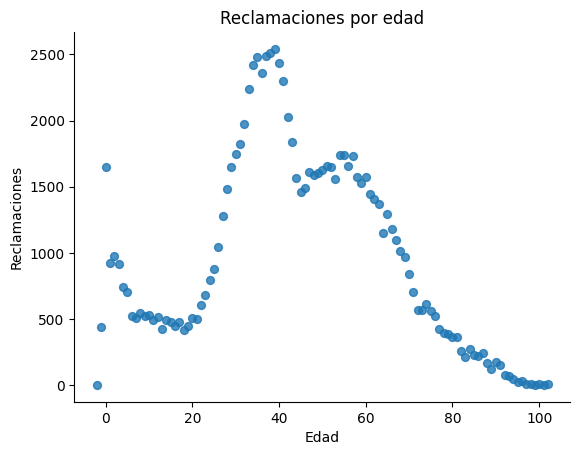

In [57]:
from matplotlib import pyplot as plt
df_edad.plot(kind='scatter', x='Edad', y='Reclamaciones', s=32, alpha=.8, title='Reclamaciones por edad')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [58]:
#se comprueban edades negativas y edades con un valor de 0.
#se validaran estos numeros con una columna de edad_2, calculada apartir de la fecha de nacimiento y la fecha de la reclamacion.
df_completa_1["dias_edad"]=(df_completa_1['Fecha_Reclamacion']-df_completa_1["FechaNacimiento"]).dt.days#.astype("<m8[m]")
df_completa_1["Edad_2"]=df_completa_1["dias_edad"]/365.2425

la variable Edad_2 da como resultado los años en decimas de año, por loq ue algunos valores antes 0, ahora son calores menores a 1, que significan menos de 365 dias/12 meses de edad

In [59]:
#ahora vamos a comprobar las condiciones solo con las variables involucradas en la edad
diag_edad_neg=df_completa_1[["Fecha_Reclamacion","FechaNacimiento","Edad","Edad_2","dias_edad","Diagnostico_Codigo"]][df_completa_1["Edad"]<=-1]
#vamos a remplazar los valores del diagnostico, para encontrar alguna relacion
remp1=dict(zip(df_diag['Diagnostico_Codigo'],df_diag["Diagnostico_Desc"]))
diag_edad_neg["Diagnostico_Codigo"]=diag_edad_neg["Diagnostico_Codigo"].replace(remp1)
pd.set_option('display.max_colwidth', None)
diag_edad_neg

Fecha_Reclamacion FechaNacimiento  Edad    Edad_2  dias_edad  \
41            2019-09-06      2019-09-20  -1.0 -0.038331        -14   
593           2019-09-25      2019-10-19  -1.0 -0.065710        -24   
726           2019-10-30      2019-11-04  -1.0 -0.013690         -5   
863           2019-11-07      2019-11-29  -1.0 -0.060234        -22   
1177          2019-10-21      2019-10-25  -1.0 -0.010952         -4   
...                  ...             ...   ...       ...        ...   
98729         2019-09-30      2019-10-21  -1.0 -0.057496        -21   
99515         2019-04-26      2019-05-05  -1.0 -0.024641         -9   
99628         2019-11-26      2019-12-10  -1.0 -0.038331        -14   
99790         2019-09-28      2019-10-22  -1.0 -0.065710        -24   
100006        2019-12-08      2019-12-20  -1.0 -0.032855        -12   

                                                                    Diagnostico_Codigo  
41           CARCINOMA IN SITU DE LA GLÁNDULA TIROIDES Y DE OTRAS GLÁNDULAS ENDOCRINAS  
593                         DIFICULTAD RESPIRATORIA DEL RECIÉN NACIDO, NO ESPECIFICADA  
726                                                   EXAMEN DE OÍDOS Y DE LA AUDICIÓN  
863                              SÍNDROME DE DIFICULTAD RESPIRATORIA DEL RECIÉN NACIDO  
1177                                              BRONQUIOLITIS AGUDA, NO ESPECIFICADA  
...                                                                                ...  
98729                       DIFICULTAD RESPIRATORIA DEL RECIÉN NACIDO, NO ESPECIFICADA  
99515   OTROS CONTROLES GENERALES DE SALUD DE RUTINA DE OTRAS SUBPOBLACIONES DEFINIDAS  
99628                                                   CONVULSIONES DEL RECIÉN NACIDO  
99790                             SEPSIS BACTERIANA DEL RECIÉN NACIDO, NO ESPECIFICADA  
100006                                            BRONQUIOLITIS AGUDA, NO ESPECIFICADA  

[437 rows x 6 columns]

Vemos como comun diagnosticos relacionados con recien nacido, asi que se va a suponer que la fecha de reclamacion es menor a la de nacimiento, porque la madre ingreso dias antes del nacimiento por algun sintoma o patologia de ella, o del feto/recien nacido, por lo que la edad negativa se remplazara por 1 dia de nacido o

In [60]:
#se remplazan los valores y ademas se elimina registro con edad=-2 ya que no hya ingunindicio de que sea un recien nacido y se considerara como un atipico
df_completa_1.loc[df_completa_1["Edad_2"]<0,"Edad_2"]=1/365.2425
df_completa_1=df_completa_1.drop(df_completa_1[df_completa_1["Edad"]==-2].index)

In [61]:
#ahora analizamos los valores con edades de 0
df_completa_1[df_completa_1["Edad_2"]==0]
#se comprueba que nacen el mismo dia del registro de la reclamacion, su valor sera remplazado por edad de 1 dia.
df_completa_1.loc[df_completa_1["Edad_2"]==0,"Edad_2"]=1/365.2425

In [62]:
pd.DataFrame(df_completa_1["Edad_2"].value_counts()).reset_index().rename(columns={'index': 'Edad',"Edad_2":"Reclamaciones"}).sort_values(by='Edad')


Edad  Reclamaciones
0        0.002738            462
194      0.005476             12
1593     0.008214              8
698      0.010952             10
13       0.013690             16
...           ...            ...
22830  102.091076              1
22155  102.293682              1
28029  102.299157              1
26688  102.315585              1
21737  102.436053              1

[28129 rows x 2 columns]

In [63]:
#se elimina la antigua variable Edad y se limitan los decimales de la variable edad_2 a dos decimales
df_completa_2 = df_completa_1.drop(columns=['Edad','dias_edad'])
df_completa_2 = df_completa_2.rename(columns={'Edad_2': 'Edad'})
df_completa_2['Edad'] = df_completa_2['Edad'].round(2)
df_completa_2.head(2)

Fecha_Reclamacion  Afiliado_Id Reclamacion_Cd Diagnostico_Codigo  \
0        2019-10-28      7567894            R14               N649   
1        2019-12-23     12170310            R14               R529   

   Numero_Utilizaciones  Valor_Utilizaciones  Sexo_Cd FechaNacimiento  \
0                     1               139376      1.0      1979-05-10   
1                     1               135179      1.0      1979-04-14   

  Regional  CANCER  EPOC  DIABETES  HIPERTENSION  ENF_CARDIOVASCULAR  mes_rec  \
0       40     0.0   0.0       0.0           0.0                 0.0       10   
1       40     0.0   0.0       0.0           0.0                 0.0       12   

   año_rec  mes_nac   Edad  
0     2019        5  40.47  
1     2019        4  40.69

In [64]:
df_completa_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100677 entries, 0 to 100677
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Fecha_Reclamacion     100677 non-null  datetime64[ns]
 1   Afiliado_Id           100677 non-null  int64         
 2   Reclamacion_Cd        100677 non-null  object        
 3   Diagnostico_Codigo    100677 non-null  object        
 4   Numero_Utilizaciones  100677 non-null  int64         
 5   Valor_Utilizaciones   100677 non-null  int64         
 6   Sexo_Cd               100677 non-null  float64       
 7   FechaNacimiento       100677 non-null  datetime64[ns]
 8   Regional              100677 non-null  object        
 9   CANCER                100677 non-null  float64       
 10  EPOC                  100677 non-null  float64       
 11  DIABETES              100677 non-null  float64       
 12  HIPERTENSION          100677 non-null  float64       
 13 

In [65]:
df_completa_2["Regional"]=df_completa_2["Regional"].astype("int")

In [66]:
print("Regional: \n",df_completa_2["Regional"].value_counts())

Regional: 
  50    63841
 40    15224
 20    10520
 10     9116
 30     1972
-1         4
Name: Regional, dtype: int64


In [67]:
#eliminamos registro sin informacion regional
df_completa_2 = df_completa_2.drop(df_completa_2[df_completa_2["Regional"] == -1].index)

In [68]:
print("Regional: \n",df_completa_2["Regional"].value_counts())

Regional: 
 50    63841
40    15224
20    10520
10     9116
30     1972
Name: Regional, dtype: int64


##Exploracion grafica base completa

###Previas a la exploracion

In [69]:
df_completa_3=df_completa_2.copy()

In [70]:
#volvemos a crear columna edad para el analisis
df_completa_3["Edad"]=(df_completa_3['Fecha_Reclamacion']-df_completa_3["FechaNacimiento"]).astype("<m8[Y]")
#ponemos todos los valores iguales o menores a 0 a -1, loq ue significa que la edad es menor a un año
df_completa_3.loc[df_completa_3["Edad"]<=0,"Edad"]=-1

In [71]:
#pasamos diccionario reg a object
df_reg["Regional_Id"]=df_reg["Regional_Id"].astype("int")

In [72]:
#para faciliar analisis grafico, se crea base de datos donde se incorporan los significados de los diagnosticos, reclamaciones, sexo y regional
remp1=dict(zip(df_diag['Diagnostico_Codigo'],df_diag["Diagnostico_Desc"]))
remp2=dict(zip(df_gen['Sexo_Cd'],df_gen["Sexo_Cd.1"]))
remp3=dict(zip(df_reg['Regional_Id'],df_reg["Regional_desc"]))
remp4=dict(zip(df_recl['Reclamacion_Cd'],df_recl["Reclamacion_Desc"]))
df_completa_3["Diagnostico_Codigo"]=df_completa_3["Diagnostico_Codigo"].replace(remp1)
df_completa_3["Sexo_Cd"]=df_completa_3["Sexo_Cd"].replace(remp2)
df_completa_3["Regional"]=df_completa_3["Regional"].replace(remp3)
df_completa_3["Reclamacion_Cd"]=df_completa_3["Reclamacion_Cd"].replace(remp4)
pd.set_option('display.max_colwidth', None)
df_completa_3["Cod_Diagnostico"]=df_completa_2["Diagnostico_Codigo"]
df_completa_3["Cod_Reclamacion"]=df_completa_2["Reclamacion_Cd"]

###Exploracion invidiual

In [73]:
df_completa_3

Fecha_Reclamacion  Afiliado_Id  \
0             2019-10-28      7567894   
1             2019-12-23     12170310   
2             2019-12-09      4512914   
3             2019-08-17      3212499   
4             2019-12-10      9055837   
...                  ...          ...   
100673        2019-10-25     29436599   
100674        2019-11-09      1304923   
100675        2019-12-04     13172140   
100676        2019-04-30     47260743   
100677        2019-12-16     15535648   

                                       Reclamacion_Cd  \
0                             EXAMENES DE DIAGNOSTICO   
1                             EXAMENES DE DIAGNOSTICO   
2                             EXAMENES DE DIAGNOSTICO   
3                             EXAMENES DE DIAGNOSTICO   
4       TRATAMIENTO MEDICO AMBULATORIO POR ACCIDENTES   
...                                               ...   
100673                        EXAMENES DE DIAGNOSTICO   
100674                        EXAMENES DE DIAGNOSTICO   
100675                        EXAMENES DE DIAGNOSTICO   
100676                         TRASLADO EN AMBULANCIA   
100677              CIRUGIA AMBULATORIA POR ACCIDENTE   

                                                                    Diagnostico_Codigo  \
0                                                TRASTORNO DE LA MAMA, NO ESPECIFICADO   
1                                                               DOLOR, NO ESPECIFICADO   
2       OTROS CONTROLES GENERALES DE SALUD DE RUTINA DE OTRAS SUBPOBLACIONES DEFINIDAS   
3                                                                     DOLOR PRECORDIAL   
4                                                   ESGUINCES Y TORCEDURAS DEL TOBILLO   
...                                                                                ...   
100673                                                             EMBARAZO CONFIRMADO   
100674                              INFECCIÓN DE VÍAS URINARIAS, SITIO NO ESPECIFICADO   
100675                                                HIPERTENSIÓN ESENCIAL (PRIMARIA)   
100676                                                                         CEFALEA   
100677                                TRAUMATISMO POR APLASTAMIENTO DE DEDO(S) DEL PIE   

        Numero_Utilizaciones  Valor_Utilizaciones Sexo_Cd FechaNacimiento  \
0                          1               139376       F      1979-05-10   
1                          1               135179       F      1979-04-14   
2                          1                61854       F      1952-10-26   
3                          1               182900       M      1965-10-03   
4                          1               122053       F      1972-04-29   
...                      ...                  ...     ...             ...   
100673                     1                63240       F      1988-03-27   
100674                     1               994034       F      1930-01-06   
100675                     1               256556       F      1958-09-11   
100676                     1               157370       F      2011-03-21   
100677                     1               111147       F      1989-06-15   

                  Regional  CANCER  EPOC  DIABETES  HIPERTENSION  \
0           REGIONAL NORTE     0.0   0.0       0.0           0.0   
1           REGIONAL NORTE     0.0   0.0       0.0           0.0   
2       REGIONAL OCCIDENTE     0.0   0.0       0.0           0.0   
3       REGIONAL OCCIDENTE     0.0   0.0       0.0           1.0   
4       REGIONAL OCCIDENTE     0.0   0.0       0.0           1.0   
...                    ...     ...   ...       ...           ...   
100673     REGIONAL CENTRO     0.0   0.0       0.0           0.0   
100674  REGIONAL OCCIDENTE     0.0   0.0       0.0           1.0   
100675      REGIONAL NORTE     0.0   0.0       1.0           1.0   
100676  REGIONAL OCCIDENTE     0.0   0.0       0.0           0.0   
100677      REGIONAL NORTE     0.0   0.0       0.0           0.0   

      

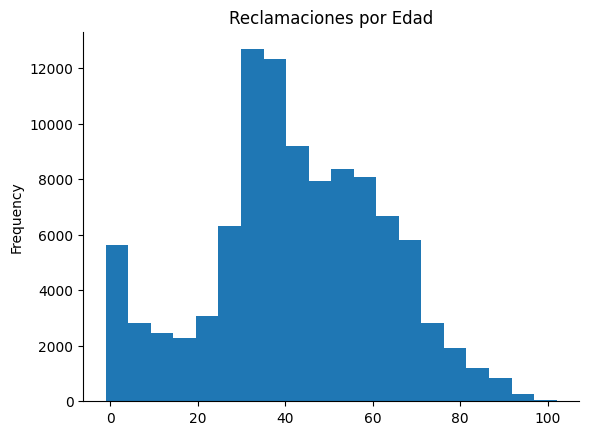

In [74]:
df_completa_3['Edad'].plot(kind='hist', bins=20, title='Reclamaciones por Edad')
plt.gca().spines[['top', 'right',]].set_visible(False)

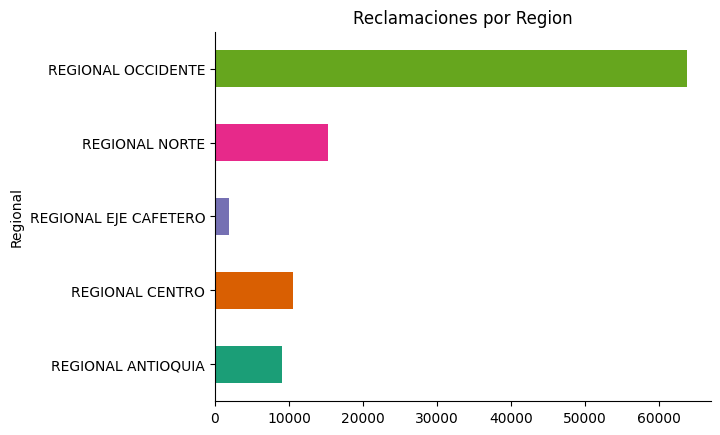

In [75]:
df_completa_3.groupby('Regional').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'),title='Reclamaciones por Region')
plt.gca().spines[['top', 'right',]].set_visible(False)

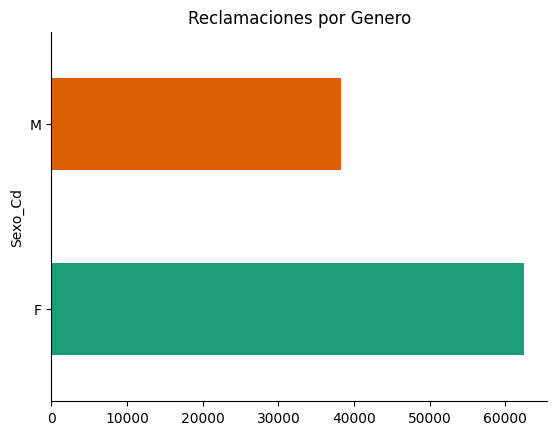

In [76]:
df_completa_3.groupby('Sexo_Cd').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'),title='Reclamaciones por Genero')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [77]:
print("Reclamaciones por genero (%): \n",((df_completa_3["Sexo_Cd"].value_counts()/len(df_completa_3))*100).round(2))

Reclamaciones por genero (%): 
 F    62.01
M    37.99
Name: Sexo_Cd, dtype: float64


El 62% de las reclamaciones son hechas por mujeres

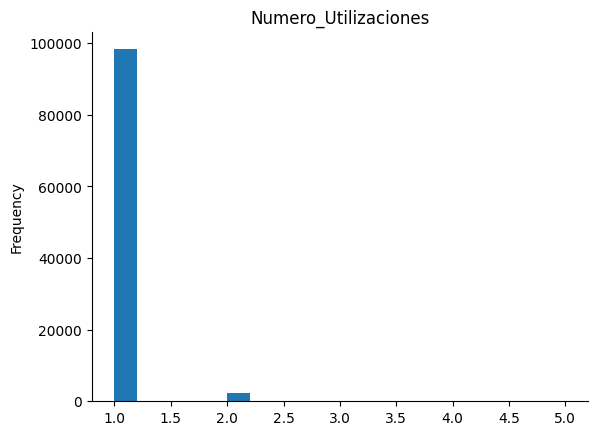

In [78]:
df_completa_3['Numero_Utilizaciones'].plot(kind='hist', bins=20, title='Numero_Utilizaciones')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [79]:
print("Numero_Utilizaciones: \n",df_completa_3["Numero_Utilizaciones"].value_counts())

Numero_Utilizaciones: 
 1    98323
2     2205
3      133
4       10
5        2
Name: Numero_Utilizaciones, dtype: int64


La mayoria de reclamaciones tienen una sola utilizacion.

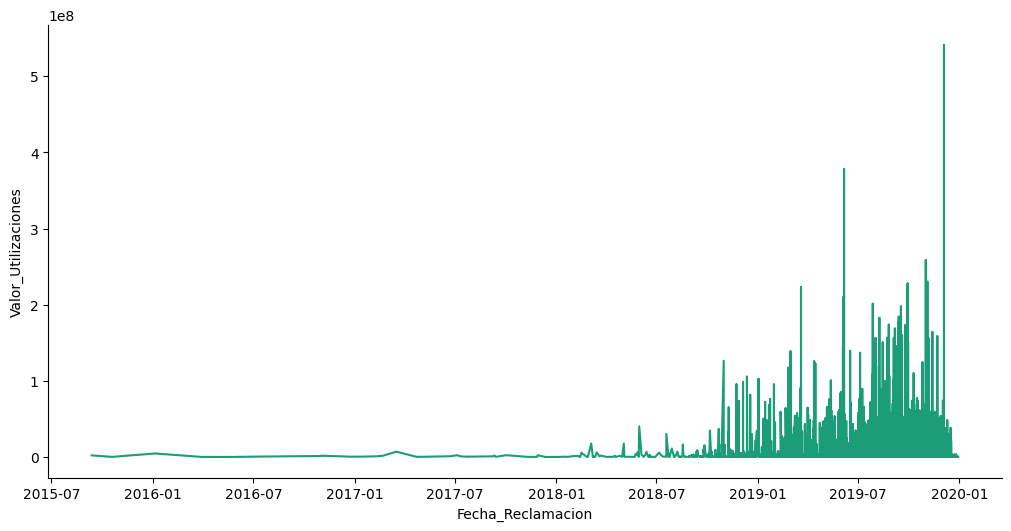

In [80]:
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Fecha_Reclamacion']
  ys = series['Valor_Utilizaciones']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_completa_3.sort_values('Fecha_Reclamacion', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Fecha_Reclamacion')
_ = plt.ylabel('Valor_Utilizaciones')

vemos como los reclamos se han hecho en su mayoria despues de 2018 y en general tienen una tendencia a subir su valor en sus valores mas altos o atipicos.

###Reporte General

In [81]:
# --- Reporte exploratorio del dataset ---
ProfileReport(df_completa_3, title='Reporte exploratorio del dataset final', minimal=True,
              progress_bar=False, interactions=None, explorative=True, dark_mode=True,
              notebook={'iframe':{'height': '600px'}}, html={'style':{'primary_color': '#FFCC00'}},
              missing_diagrams={'heatmap': False, 'dendrogram': False}).to_notebook_iframe()

Conclusiones del reporte:
* La reclamacion mas frecuente es por examenes diagnosticos, seguido de cirugias ambulatorias.
* Los diagnosticos mas frecuentes son los relacionados con algun tipo de examen.
* 50% del valor de las utilizaciones es menor a 148.254.
* solo un 5% de las reclamaciones tienen un valor superior a los 5.410.000.
* 31% de las reclamaciones se hicieron en la regional occidente, seguido de un 7,5% de la regional norte.
*solo el 7,5% de las reclamaciones son de pacientes con cancer (7553 pacientes)
* solo el 1,9% de las reclamaciones son de pacientes con EPOC(1898 pacientes).
* 8,4% de las reclamaciones son de pacientes con diabetes(8460 pacientes).
* 19,3% de las reclamaciones son de pacientes con hipertension(19463 pacientes).
* solo el 1,5% de las reclamaciones son de pacientes con efermedades cardiovasculares(1498 pacientes).
* el mes con mayor numero de reclamaciones presentadas es septiembre, con 23,8% de als reclamaciones, seguido de octubre con 23,6%.
* el 2.1% de las reclamaciones fueron para pacientes de menos de 1 año.
* La mitad de las reclamaciones fueron ehchas para pacientes con  menos de 42 años.
* El 5% del total de reclamaciones fueron hechas para pacientes con mas de 75 años
* Solo 14 reclamaciones fueron hechas para pacientes con 100 años o mas.
* el diagnostico mas comun fue el examen de laboratorio(17,1%), seguido de "otros controles generales"(9,3%) e hipotiroidismo (4%).
* la reclamacion mas frecuente fue presentada por examenes de diagnostico(50,3%), seguida de cirugia ambulatoria por enfermedad(17,8%).


#Exportar Base para modelo

##Creacion de la base

In [67]:
#Se procede a generar base de datos para utilizacion en el modelo
df_completa_modelo=df_completa_2.drop(columns=["Fecha_Reclamacion","Afiliado_Id","FechaNacimiento"])

In [68]:
df_completa_modelo.head(2)

Reclamacion_Cd Diagnostico_Codigo  Numero_Utilizaciones  \
0            R14               N649                     1   
1            R14               R529                     1   

   Valor_Utilizaciones  Sexo_Cd  Regional  CANCER  EPOC  DIABETES  \
0               139376      1.0        40     0.0   0.0       0.0   
1               135179      1.0        40     0.0   0.0       0.0   

   HIPERTENSION  ENF_CARDIOVASCULAR  mes_rec  año_rec  mes_nac   Edad  
0           0.0                 0.0       10     2019        5  40.47  
1           0.0                 0.0       12     2019        4  40.69

##Exportar base para modelo

In [ ]:
#exportar final
df_completa_modelo.to_csv("df_completa_modelo.csv",index=False)

##Exportar este archivo a HTML

1.descargar jpynb manualmente

2.cargar en la raiz del collab

3.ejecutar el siguiente codigo

4.descargar .HTML del entorno



In [ ]:
%%shell
jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/Analitica 3 2023-2/Módulo salud/clase 9 nov/clase 9nov.ipynb"